# __Applying PCM to ARGO data in Mediterranean Sea__

The aim of this notebookis to be an example of applying the PCM method to in-situ T-S profiles. The dataset is a selection of Argo profiles localted in Mediterranean sea. Notebook developped and run in __Marine Environmental Indicators JupyterLab__

Libraries needed:

In [29]:
import xarray as xr
# xr.set_options(display_style='text')
import numpy as np
import pandas as pd

import argopy
# not at home
# argopy.set_options(cachedir='/home1/homedir5/perso/agarciaj/.cache/argopy',src='localftp',local_ftp='/home/ref-argo/gdac')
from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher()
# argo_loader = ArgoDataFetcher(cache=True)
# trying parallel-requests
#argo_loader = ArgoDataFetcher(src='erddap', parallel=True, chunks={'wmo': 2})

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import seaborn as sns

import pyxpcm
from pyxpcm.models import pcm

from Plotter import Plotter #new class for plots in pyxpcm

In [30]:
dir(Plotter)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'plot_posteriors',
 'plt',
 'spatial_distribution',
 'temporal_distribution',
 'vertical_structure']

<font color=blue>__Create class plotter__</font>

In [ ]:
class Plotter:
    '''New class for data visualisation of data from pyxpcm
        ds: dataset including PCM results'''
    
    def __init__(self, ds, m, data_type):
        
        self.ds = ds
        self.m = m
        self.data_type = data_type
        # types: profiles, gridded, timeseries in the future??
        # look for latitude and longitude variables inside functions?
        
        # check if dataset should include PCM variables
        assert ("PCM_LABELS" in self.ds), "Dataset should include PCM_LABELS varible to be plotted. Use pyxpcm.predict function with inplace=True option"
        
        
    def vertical_structure(self,q_variable):
        '''Plot vertical structure of each class
           q_variable: quantile variable calculated with pyxpcm.quantile function (inplace=True option)'''
        
        # TODO: check if data is profile
        # TODO: try with other k values
        # TODO: Plot function already in pyxpcm
        fig, ax = self.m.plot.quantile(self.ds[q_variable], maxcols=4, figsize=(10, 8), sharey=True)
        
        
    def spatial_distribution(self, proj, extent, co):
        '''Plot spatial distribution of classes
           proj: projection
           extent: map extent
           co: coordinates names co={'longitude':'LONGITUDE', 'latitude':'LATITUDE'}'''
        
        subplot_kw={'projection': proj, 'extent': extent}
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)
        kmap = self.m.plot.cmap() # TODO: function already in pyxpcm
        
        # check if gridded or profiles data
        if self.data_type == 'profiles':
            sc = ax.scatter(self.ds[co['longitude']], self.ds[co['latitude']], s=3, c=self.ds['PCM_LABELS'], cmap=kmap, transform=proj, vmin=0, vmax=m.K)
        if self.data_type == 'gridded':
            sc = ax.pcolormesh(self.ds[co['longitude']], self.ds[co['latitude']], s=3, c=self.ds['PCM_LABELS'], cmap=kmap, transform=proj, vmin=0, vmax=m.K)
        
        cl = self.m.plot.colorbar(ax=ax) # TODO: function already in pyxpcm
        gl = self.m.plot.latlongrid(ax, dx=10) # TODO: function already in pyxpcm
        ax.add_feature(cfeature.LAND)
        ax.add_feature(cfeature.COASTLINE)
        ax.set_title('LABELS of the training set')
        
        # saving figure outside??
        #plt.savefig('ArgoMed_map_labels_EX.png')
        
        plt.show()
        
        
    def plot_posteriors(self, proj, extent, co):
        '''Plot posteriors in a map
           proj: projection
           extent: map extent
           co: coordinates names co={'longitude':'LONGITUDE', 'latitude':'LATITUDE'}'''
        
        # check if PCM_POST variable exists
        assert ("PCM_POST" in self.ds), "Dataset should include PCM_POST varible to be plotted. Use pyxpcm.predict_proba function with inplace=True option"
        
        cmap = sns.light_palette("blue", as_cmap=True)
        subplot_kw={'projection': proj, 'extent': extent}
        fig, ax = self.m.plot.subplots(figsize=(10,22), maxcols=2, subplot_kw=subplot_kw)# TODO: function already in pyxpcm

        for k in self.m:
            if self.data_type == 'profiles':
                sc = ax[k].scatter(self.ds[co['longitude']], self.ds[co['latitude']], s=3, c=self.ds['PCM_POST'].sel(pcm_class=k),
                           cmap=cmap, transform=proj, vmin=0, vmax=1)
            if self.data_type == 'gridded':
                sc = ax[k].pcolormesh(self.ds[co['longitude']], self.ds[co['latitude']], s=3, c=self.ds['PCM_POST'].sel(pcm_class=k),
                           cmap=cmap, transform=proj, vmin=0, vmax=1)
            
            cl = plt.colorbar(sc, ax=ax[k], fraction=0.03)
            gl = self.m.plot.latlongrid(ax[k], fontsize=8, dx=20, dy=10)
        
            ax[k].add_feature(cfeature.LAND)
            ax[k].add_feature(cfeature.COASTLINE)
            ax[k].set_title('PCM Posteriors k=%i' % k)
            
            # saving figure outside??
            #plt.savefig('ArgoMed_posteriors_EX.png')

        
    def temporal_distribution(self, time_variable, time_bins, pond):
        '''Plot temmporal distribution of classes by moth or by season
           time_variable: time variable name
           time_bins: 'month' or 'season'
           pond: 'abs' or 'rel' (divided by total nomber of observation in time bin)'''
        
        # TODO: it only works for profile type data for the moment (how to do when gridded?)
        
        # check if more than one temporal step
        assert (len(self.ds[time_variable]) > 1), "Length of time variable should be > 1"
                        
        # data to be plot
        # TODO: is it the best way??
        pcm_labels = dsi['PCM_LABELS']
       
        if time_bins == 'month':
            xaxis_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dic']
        if time_bins == 'season':
            seasons_dict = {1: 'DJF', 2: 'MAM', 3: 'JJA', 4:'SON'}
            xaxis_labels = ['DJF', 'MAM', 'JJA', 'SON']
        
        width = 0.5/(self.m.K)  # the width of the bars
        fig, ax = plt.subplots(figsize=(18,10))

        #loop in k and counting in months
        for cl in range(self.m.K):
            #get time array with k=cl
            pcm_labels_k = pcm_labels[pcm_labels == cl]
            # count for each month
            counts_k = pcm_labels_k.groupby(time_variable + '.' + time_bins).count()
            
            if pond == 'rel':
                counts_k = counts_k/sum(counts_k)
            
            if time_bins == 'month':
                bar_plot_k = ax.bar(counts_k.month - (m.K/2-cl)*width, counts_k, width, label = ['K =' + str(cl)])
            if time_bins == 'season':
                x_ticks_k = []
                for i in range(len(counts_k.season)):
                    x_ticks_k.append(list(seasons_dict.values()).index(counts_k.season[i])+1)
                    # print(x_ticks_k)
                #plot
                bar_plot_k = ax.bar(np.array(x_ticks_k) - (m.K/2-cl)*width, counts_k, width, label = ['K =' + str(cl)])
            
    
        # format
        # TODO: titles when pond = 'rel'
        ax.set_xticks(np.arange(1,len(xaxis_labels)+1))
        ax.set_xticklabels(xaxis_labels, fontsize=12)
        plt.yticks(fontsize=12)
        ax.legend(fontsize=12)
        ax.set_ylabel('Number of profiles',fontsize=12)
        ax.set_title('Number of profiles for each class by month', fontsize=14)
        fig.tight_layout()

        # saving figure outside??
        # plt.savefig('ArgoMed_months_hist_EX.png')

        plt.show()
        
    pass

## Getting data
***

We acces to data using argopy python library

<font color=red>TODO</font>: region option makes a square around Mediterranean sea, including some profiles in Black Sea and Atlantic Ocean --> Try to access data using WMO and profile number

In [2]:
# only one year
ds = argo_loader.region([-6, 35, 30, 46, 0, 1000, '2012', '2013']).to_xarray()
#ds

<font color=red>TODO</font>: try to use more than one year (memory limits ?)

In [3]:
# trying yo use more than one year
#ds1 = argo_loader.region([30, 46, -6, 35, 0, 1000, '2011', '2012']).to_xarray()
#ds2 = argo_loader.region([30, 46, -6, 35, 0, 1000, '2012', '2013']).to_xarray()
#ds = xr.concat([ds1,ds2],dim='N_POINTS')
#ds

In [3]:
dsp = ds.argo.point2profile()
#dsp

In [4]:
# interpolation to standard levels
z = np.arange(0.,1000,10.)
#z

with `z = np.arange(0.,200,1.)` interpolation is not working

In [5]:
dsi = dsp.argo.interp_std_levels(z)
#dsi

Pressure should be negative to fit the model

In [6]:
dsi['PRES_INTERPOLATED'] = -dsi.PRES_INTERPOLATED
#dsi

## Applying PCM
***

We creates a model with K classes and temperature or salinity or both as features

### Create PCM

In [7]:
z = np.arange(0.,-1000,-10.)
# only temperature to try temporal representation
# pcm_features = {'temperature': z, 'salinity' : z}
pcm_features = {'temperature': z}
m = pcm(K=8, features=pcm_features)
m

<pcm 'gmm' (K: 8, F: 1)>
Number of class: 8
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

### Fit model

In [8]:
# only temperature to try temporal representation
# features_in_ds = {'temperature': 'TEMP', 'salinity': 'PSAL'}
features_in_ds = {'temperature': 'TEMP'}
features_zdim='PRES_INTERPOLATED'
m.fit(dsi, features=features_in_ds, dim=features_zdim)
m

<pcm 'gmm' (K: 8, F: 1)>
Number of class: 8
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: -2.057540

<font color=red>__TODO__</font> : save all trained PCM in a folder

### Classify data

In [9]:
m.predict(dsi, features=features_in_ds, dim=features_zdim, inplace=True);
#dsi

In [10]:
m.predict_proba(dsi, features=features_in_ds, dim=features_zdim, inplace=True);
#dsi

In [11]:
dsi = dsi.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of='TEMP', outname='TEMP' + '_Q', keep_attrs=True, inplace=True);
# dsi = dsi.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of='PSAL', outname='PSAL' + '_Q', keep_attrs=True, inplace=True)
#dsi

In [ ]:
dsi

## Visualisation
***

Initialize Plotter

In [31]:
P = Plotter(dsi, m, data_type = 'profiles')

#### 1. Vertical structure of classes

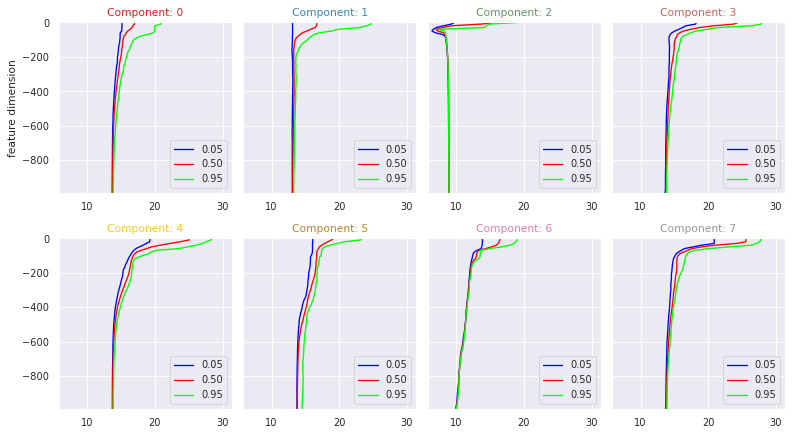

In [21]:
P.vertical_structure(q_variable = 'TEMP_Q')

#### 2. Spatial distribution of classes

In [32]:
P.spatial_distribution(proj=ccrs.PlateCarree(), extent=np.array([-10,40,30,56]) + np.array([-0.1,+0.1,-0.1,+0.1]), 
                       co = {'latitude':'LATITUDE', 'longitude':'LONGITUDE'})

NameError: name 'plt' is not defined

#### 3. Posteriors

In [ ]:
P.plot_posteriors(proj=ccrs.PlateCarree(), extent=np.array([-10,40,30,56]) + np.array([-0.1,+0.1,-0.1,+0.1]), 
                       co = {'latitude':'LATITUDE', 'longitude':'LONGITUDE'})

#### 4. Temporal representation

In [ ]:
# data to be plot
pcm_labels = dsi['PCM_LABELS']
#pcm_labels

Simple histogram

In [ ]:
fig, axes = plt.subplots()
pcm_labels.plot.hist()
# y axis is number of profiles
axes.set_ylabel('Number of profiles')
plt.show()

Bar plot by __month__

In [ ]:
P.temporal_distribution(time_variable = 'TIME', time_bins = 'month', pond = 'abs')

Bar plot by __month__ (__relative__ number of profiles per month)

In [ ]:
P.temporal_distribution(time_variable = 'TIME', time_bins = 'month', pond = 'rel')

Bar plot by __season__

In [ ]:
P.temporal_distribution(time_variable = 'TIME', time_bins = 'season', pond = 'rel')